# Titanic Survival Classification - A Basic Model (Part 2)

So now I've imported and played around with the data a bit its time to have a look at the data more closely and get started building a basic model from scratch.

As this is my first model what better place to start than a simple logistic regression model to get into the swing of things.

So lets get started by importing the basic packages we'll be using and the data/functions we built in Part 1.

In [1]:
#First importing some relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Import the functions built in Part 1
from Titanic_Import import *


F:\anaconda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now we have our modules its time to import our data and do some basic analysis.

In [2]:
full_set = pd.read_csv('D:/Datasets/Titanic/train.csv')

#import data we cleansed last time
X_Train, X_CV, Y_Train, Y_CV = Cleanse_Training_Data(full_set)


So first thing's first: lets have a look at our feature correlation.  

We are expecting our features to be somewhat correlated here due to the nature of OH vectors but lets see.

So we're going to do this by means of Principle Component Analysis. 

In [3]:
def compute_pca(X):
    m = X.shape[0]
    sigma = (1/m) *(np.matmul(np.transpose(X), X))
    sig_rep = np.nan_to_num(sigma)
    U, S, T = np.linalg.svd(sig_rep)
    return U, S

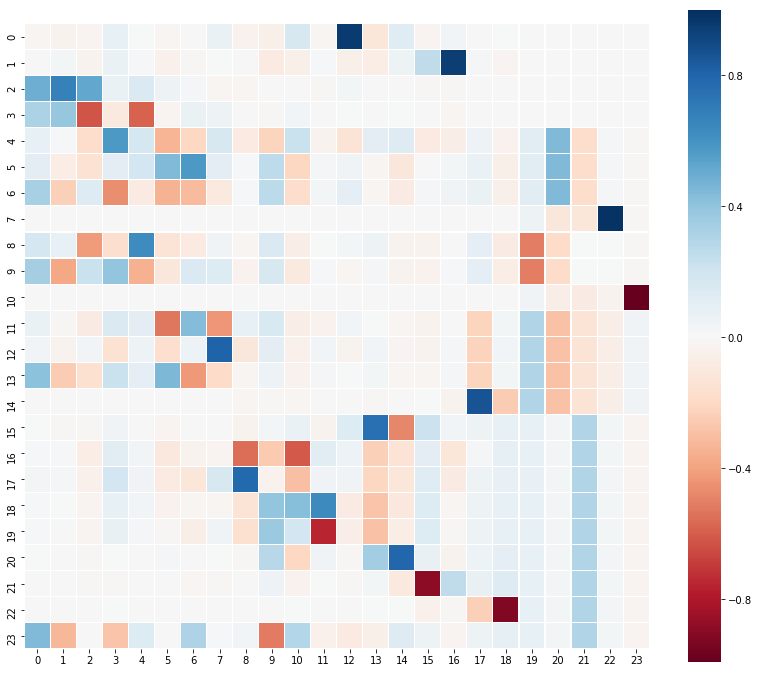

In [4]:
U, S = compute_pca(X_Train)

#Plot our output to have a look
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
sns.heatmap(U, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap,linecolor='white')

So our OH vectors appear somewhat correlated (as expected) but other than that most of our features are uncorellated assuming I'm reading the chart correctly.  

There are a few highly correlated features as well such as 7 and 22, however overall we're not looking too bad.  


# Logistic Regression

So lets build our first simple model - Logistic Regression.

We're doing this from the ground up so lets get to it.

This is going to be a cut down build with some functionality added to test, however its only a proof of concept.

So first things first lets build all the functions we will need - 
* Random Initializer function
* Logistic Regression Forward Propogation function
* Optimization algorithm(s)
* Backward Propogation/Training function
* Prediction function 

In [5]:
#Sigmoid Activation Function
def sigmoid(z):
    s = 1/(1+np.exp(-z))  
    return s

#Random Initializer
def initializer(dim):   
    w = np.random.uniform(-1,0,(dim, 1))
    b = np.random.uniform()
    return w, b

#One full pass
def Logistic_Reg(X, Y, w, b, regularizer = None , ld = 0.5):
    m = X.shape[0]

    #Forward Prop
    Z = np.nansum(w*X.T, axis = 0 ) + b
    A = sigmoid(Z) 
    
    #Logistic Cross-Entropy Loss
    if regularizer == "L2" :
        #L2 Regularization
        reg = (ld / (2*m)) * np.asscalar(np.matmul(w.T, w))
        cost = -(1/m)*np.nansum(Y*np.log(A) +(1 - Y)*np.log(1 - A)) + reg
    if regularizer == "L1" :
        #L1 Regularization
        reg = (ld / (2*m)) * np.sum(np.absolute(w))
        cost = -(1/m)*np.nansum(Y*np.log(A) +(1 - Y)*np.log(1 - A)) + reg
    else :
        #defaults to no regularization
        cost = -(1/m)*np.nansum(Y*np.log(A) +(1 - Y)*np.log(1 - A))
    
    
    
    #Gradients
    dZ = np.reshape(A - Y, (m, 1))
    dw = np.matmul(X.T, dZ) / m
    db = (1/m)*np.sum(dZ)

    #cache and output
    cache = {"dw": dw,
             "db": db}
    return cost, cache

#ADAM optimization algorithm for quickly training our logistic regression parameters
def adam_optmize(w, b, dw, db, v, s, t = 2, learning_rate = 0.1, Beta1 = 0.9, Beta2 = 0.999,  epsilon = 1e-8) :
    #Compute moving averages
    v["dw"] = v["dw"]*Beta1 + (1-Beta1)*dw
    v["db"] = v["db"]*Beta1 + (1-Beta1)*db
    
    #Compute bias-corrected first moment
    v_cor_dw = v["dw"] / (1 - (Beta1**t))
    v_cor_db = v["db"] / (1 - (Beta1**t))
    
    #Moving averages for squared grads
    s["dw"] = s["dw"]*Beta2 + (1-Beta2)*(np.square(dw))
    s["db"] = s["db"]*Beta2 + (1-Beta2)*(db**2)
    
    #Compute bias-corrected second moment 
    s_cor_dw = s["dw"] / (1 - (Beta2**t))
    s_cor_db = s["db"] / (1 - (Beta2**t))
    
    #Update parameters
    w = w - (learning_rate * (v_cor_dw / (np.sqrt(s_cor_dw) + epsilon)))
    b = b - (learning_rate * (v_cor_db / (np.sqrt(s_cor_db) + epsilon)))
    
    return w, b, v, s


#Optimization function to compute our weights matrix
def Train_model(w, b, X, Y, num_iterations, learning_rate = 0.5, regularizer = None, optimizer = None, decay=None, conv = None):
    costs = []
    k = 1.5
    
    
    #If using ADAM then initialize adam parameters
    if optimizer == "adam" :
        v = {}
        s = {}
        v["dw"] = np.zeros((w.shape))
        v["db"] = 0
        s["dw"] = np.zeros((w.shape))
        s["db"] = 0
        
    
    #iterate over n passes
    for i in range(num_iterations):
        #Propogate our network per iteration
        cost, grads = Logistic_Reg(X, Y, w, b, regularizer = regularizer)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        if decay == "power" :
            learning_rate = 0.95** i
        elif decay == "inv_sqrt"  and i > 1:
            learning_rate = k / np.sqrt(i)
        elif decay == "pow_inv" and i > 1 :
            learning_rate = k ** (1/i)
        
        if optimizer == "adam" :
            w, b, v, s = adam_optmize(w, b, dw, db, v, s, learning_rate = learning_rate)
        else :
            #Gradient Descent as default
            w = w - learning_rate*dw
            b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        j = len(costs)
        
        if conv == True and  j >= 3 and  costs[j - 1] < cost and costs[j - 1] < cost :
            print("Converged after iteration %d", i)
            break
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

#Prediction function for generating outputs - effectively forward prop
#Would use softmax for multi-class however this is binary so can use simple logic
def predict(w, b, X):
    Y_pred = np.zeros((X.shape[0]))
    
    Z = np.nansum(w*X.T, axis = 0 ) + b
    A = sigmoid(Z) 
    
    for i in range(A.shape[0]):
        if A[i] > 0.5 :
            Y_pred[i] = 1
        else :
            Y_pred[i] = 0
    
    return Y_pred


So now we have the skeleton build lets test a bit.  So lets first test out regularization - comparing unregularized, L1 regularization and L2 regularization.  

0.4332607088065584


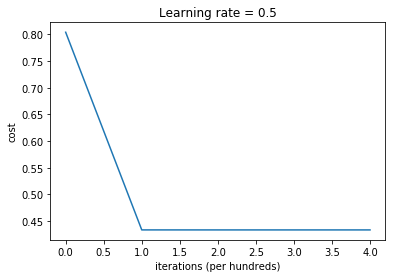

In [6]:
w, b = initializer(X_Train.shape[1])

X = X_Train
Y = Y_Train

params1, grads1, costs1 = Train_model(w, b, X, Y, 500, optimizer = "adam", decay="power")


print(costs1[-1])
plt.plot(costs1)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.5")
plt.show()


0.4429329515540734


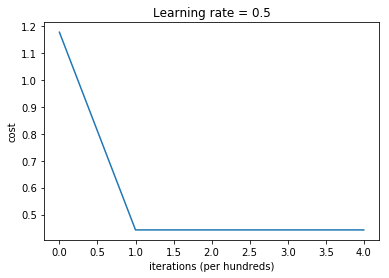

In [7]:
w, b = initializer(X_Train.shape[1])
params2, grads2, costs2 = Train_model(w, b, X, Y, 500, regularizer = "L1", optimizer = "adam",decay="power")


print(costs2[-1])
plt.plot(costs2)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.5")
plt.show()




0.43318023851744486


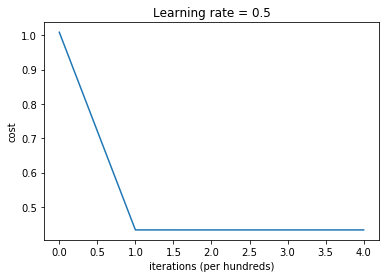

In [8]:
w, b = initializer(X_Train.shape[1])
params3, grads3, costs3 = Train_model(w, b, X, Y, 500, regularizer = "L2", optimizer = "adam", decay="power")


print(costs3[-1])
plt.plot(costs3)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate = 0.5")
plt.show()



So we want a regularized model to not overfit, however as a baseline it looks like we cannot really get better than a cost of 4.3327.  

At a glance it looks like the L2 regularization outperforms L1 regularization however lets compute some F1 scores for our model to get a proper comparison.

Note however that all models converge extremely quickly, likely due to a small training dataset (also the reason I opted for batch training over implementing mini-batch functionality).

## Computing F1 Score

So as our benchmark score to model we're going to use a combination of accuracy and the F1 score defined as - 

Precision $ = \dfrac{t_p}{t_p + f_p}$

Recall $ = \dfrac{t_p}{t_p + f_n}$

F1 Score $ = 2 \cdot \dfrac{precision \cdot recall}{precision + recall}$

In [9]:
#Calculate our accuracy figures
def Calc_Accuracy(Y_true, Y_hat) :
    #Compute inverse vectors for vectorization
    Y_true_inv = 1 - Y_true
    Y_hat_inv = 1 - Y_hat
    
    #Vectorized confusion matrix sums
    true_pos = np.sum(Y_true*Y_hat)
    false_pos = np.sum(Y_true_inv*Y_hat)
    true_neg = np.sum(Y_true_inv*Y_hat_inv)
    false_neg = np.sum(Y_true*Y_hat_inv)
    
    #F1 Score computations
    prec = true_pos / (true_pos + false_pos)
    rec = true_pos / (true_pos + false_neg)
    
    acc = float((np.dot(Y_true,Y_hat.T) + np.dot(Y_true_inv,Y_hat_inv.T))/float(Y_true.size)*100)
    score= 2 * ((prec*rec) / (prec+rec))
    confusion_mat = pd.DataFrame({
        "Actual False" : [false_pos, true_neg],
        "Actual True" : [true_pos, false_neg],
        "Labels" : ["Pred True", "Pred False"]
    }
    )
    
    return acc, score, confusion_mat

# Evaluating our models

So to evaluate the models lets use our prediction and evaluation functions to compute the statistics for all of our models.  Now as we have a holdout cross validation set we can have a test to see how our models perform on data they've never seen before.  

This should give a estimation of about what accuracy we're looking at should we submit one of these models on the test set.

### Model 1 (No Regularization)|

#### Training Performance

In [10]:
Y_hat1 = predict(params1["w"], params1["b"], X_Train)


acc1, score1, conf1 = Calc_Accuracy(Y_Train, Y_hat1)

print("Accuracy = ", acc1)
print("F1 Score = ", score1)
print("")
print("Confusion Matrix")
conf1[["Labels", "Actual True", "Actual False"]]

Accuracy =  81.16308470290771
F1 Score =  0.749579831932773

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,223.0,66.0
1,Pred False,83.0,419.0


#### Cross Validation Performance

In [11]:
Y_hat_CV1 = predict(params1["w"], params1["b"], X_CV)


acc_CV1, score_CV1, conf_CV1 = Calc_Accuracy(Y_CV, Y_hat_CV1)

print("Accuracy = ", acc_CV1)
print("F1 Score = ", score_CV1)
print("")
print("Confusion Matrix")
conf_CV1[["Labels", "Actual True", "Actual False"]]

Accuracy =  82.0
F1 Score =  0.7428571428571428

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,26.0,8.0
1,Pred False,10.0,56.0


### Model 2 (L1 Regularization)

#### Training Performance

In [12]:
Y_hat2 = predict(params2["w"], params2["b"], X_Train)


acc2, score2, conf2 = Calc_Accuracy(Y_Train, Y_hat2)

print("Accuracy = ", acc2)
print("F1 Score = ", score2)
print("")
print("Confusion Matrix")
conf2[["Labels", "Actual True", "Actual False"]]

Accuracy =  81.16308470290771
F1 Score =  0.7504187604690117

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,224.0,67.0
1,Pred False,82.0,418.0


#### Cross Validation Performance

In [13]:
Y_hat_CV2 = predict(params2["w"], params2["b"], X_CV)


acc_CV2, score_CV2, conf_CV2 = Calc_Accuracy(Y_CV, Y_hat_CV2)

print("Accuracy = ", acc_CV2)
print("F1 Score = ", score_CV2)
print("")
print("Confusion Matrix")
conf_CV2[["Labels", "Actual True", "Actual False"]]

Accuracy =  82.0
F1 Score =  0.7428571428571428

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,26.0,8.0
1,Pred False,10.0,56.0


### Model 3 - L2 Regularization

#### Training Set Performance

In [14]:
Y_hat3 = predict(params3["w"], params3["b"], X_Train)


acc3, score3, conf3 = Calc_Accuracy(Y_Train, Y_hat2)

print("Accuracy = ", acc3)
print("F1 Score = ", score3)
print("")
print("Confusion Matrix")
conf3[["Labels", "Actual True", "Actual False"]]

Accuracy =  81.16308470290771
F1 Score =  0.7504187604690117

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,224.0,67.0
1,Pred False,82.0,418.0


#### Cross Validation Performance

In [15]:
Y_hat_CV3 = predict(params3["w"], params2["b"], X_CV)


acc_CV3, score_CV3, conf_CV3 = Calc_Accuracy(Y_CV, Y_hat_CV3)

print("Accuracy = ", acc_CV3)
print("F1 Score = ", score_CV3)
print("")
print("Confusion Matrix")
conf_CV3[["Labels", "Actual True", "Actual False"]]

Accuracy =  83.0
F1 Score =  0.746268656716418

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,25.0,6.0
1,Pred False,11.0,58.0


# Results

Note that these may differ due to random initialization.

Model | Test Accuracy | Test F1 Score | CV Accuracy | CV F1 Score
--- | --- | --- | --- | ---
No Regularization | 81.036 | 0.748 | 83 | 0.753
L1 Regularization | 80.91 | 0.747 | 82 | 0.742
L2 Regularization | 80.91 | 0.747 | 84 | 0.757

So it appears no regularization had okay performance on the cross validation set so we did not overfit our data.  Interestingly both forms of regularization performed identically on the training set (confirmed after a few different random initializations), however perform differently on the cross validation set.  

It seems like L2 regularization performs the best at a glance, however this would require a few more iterations of random initialization to confirm.

However this is unlikely to yield much benefit as we are underfitting our data it seems.  

An 80% accuracy is great for a linear model, however I think a more complex model is in order to better fit our data.  And for that we will be using some more sophisticated packages instead of coding everything manually.

Part 3 to follow.